In [1]:
import os
import sys
import time
import torch
import torch.utils.data as data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid
from collections import OrderedDict
from os.path import join, dirname, exists
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pdb
cuda = torch.cuda.is_available()
cuda
device = torch.device("cuda" if cuda else "cpu")

In [2]:
SEED = 1
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

### DATA SET 

In [3]:
brush_strokes = np.load('../data_brushstrokes/brush_strokes_16x32_vae.npy')

In [4]:
# INFO 
print('Dataset: ', brush_strokes.shape)
print('One data sample shape: ', brush_strokes[0].shape)

Dataset:  (742, 16, 32)
One data sample shape:  (16, 32)


In [5]:
def imshow(img): 
    plt.imshow(img, cmap='gray_r') # 32 , 32
    plt.show()  

In [6]:
def partition_dataset(dataset, percentage_train, logs=True):
    # 1) Shuffle dataset
    s = np.random.shuffle(dataset)
    
    # 2) Make mask to make the white pixels white 
    dataset[dataset > 0.9] = 1
    
    # 2) Get numbers for train and test 
    num_train_samples = int(percentage_train * dataset.shape[0])
    train_set = dataset[:num_train_samples]
    test_set = dataset[num_train_samples: ]
    if logs:
        print('\nDividing dataset into:')
        print('Train set: ', train_set.shape[0])
        print('Test set: ', test_set.shape[0])
    return train_set, test_set

In [7]:
training_data, test_data = partition_dataset(brush_strokes, .8)


Dividing dataset into:
Train set:  593
Test set:  149


(16, 32)


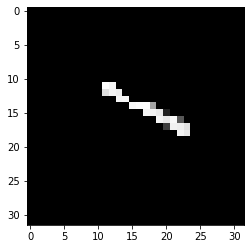

In [8]:
np.set_printoptions(threshold=sys.maxsize)
a = training_data[0]
print(a.shape)
b = np.pad(a, ((8,8),(0,0)), 'constant', constant_values=(1))
imshow(b)

In [9]:
# Class to prepare data to pytorch engine
class MyDataset(data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        img = self.X[index]
        img = np.pad(img, ((8,8),(0,0)), 'constant', constant_values=(1))
        img = torch.from_numpy(img).float()
        img = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])(img)
        return img, 0

In [10]:
batch_size = 8
transforms_ = transforms.ToTensor()
train_dataset = MyDataset(training_data)
train_loader = data.DataLoader(train_dataset, shuffle = True, batch_size = batch_size)

test_dataset = MyDataset(test_data)
test_loader = data.DataLoader(test_dataset, shuffle = False, batch_size = batch_size)

In [11]:
len(train_loader), len(test_loader)

(75, 19)

### VISUALIZATION

In [12]:
def imshow(img):
    img = img.numpy().squeeze(0)  # 1, 32, 32
    plt.imshow(img, cmap='gray_r') # 28, 28
    plt.show()  

def visualize_one_batch(loader, logs=False):
    # Visualizes one full batch of images
    for i, (x,_) in enumerate(loader):
        if i > 0: break
        if logs:
            print('shape of batch of images: ', x.shape)

        for img in x:
            imshow(img)
            if logs:
                img = img.numpy()
        
def show_samples_(samples, fname=None, nrow=10, title='Samples'):
    print('SAMPLES AS THEY COME: ', samples.shape)
    samples = torch.FloatTensor(samples)
    grid_img = make_grid(samples, nrow=nrow)
    print('grid img shape: ', grid_img.shape)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    plt.show()
    
    
def savefig(folder_name, show_figure=True):
    """
    Creates a folder to save the figures if it doesn't exist. Shows figures if opt=true
    """
    if not exists(dirname(folder_name)):
        os.makedirs(dirname(folder_name))
    plt.tight_layout()
    plt.savefig(folder_name)
    if show_figure:
        plt.show()
    
def plot_vae_training_plot(train_losses, test_losses, title, fname):
    elbo_train, recon_train, kl_train = train_losses[:, 0], train_losses[:, 1], train_losses[:, 2]
    elbo_test, recon_test, kl_test = test_losses[:, 0], test_losses[:, 1], test_losses[:, 2]
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, elbo_train, label='-elbo_train')
    plt.plot(x_train, recon_train, label='recon_loss_train')
    plt.plot(x_train, kl_train, label='kl_loss_train')
    plt.plot(x_test, elbo_test, label='-elbo_test')
    plt.plot(x_test, recon_test, label='recon_loss_test')
    plt.plot(x_test, kl_test, label='kl_loss_test')

    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    savefig(fname)

shape of batch of images:  torch.Size([8, 1, 32, 32])


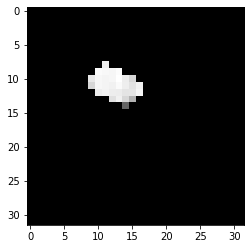

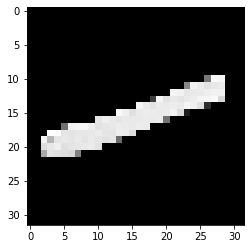

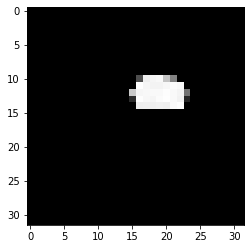

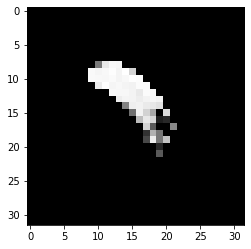

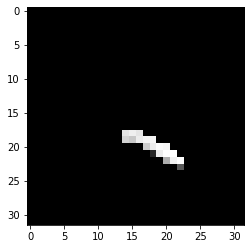

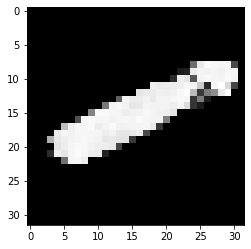

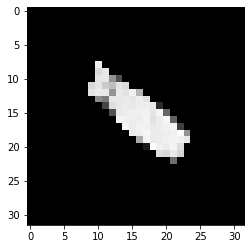

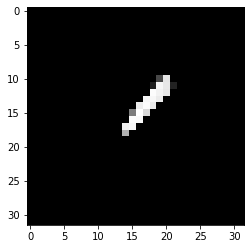

In [13]:
visualize_one_batch(test_loader, True)

### Model

In [14]:
class MLP_VAE(nn.Module):
    def __init__(self, ZDIMS):
        super(MLP_VAE, self).__init__()
        self.z_dims = ZDIMS
        # ENCODER
        # 32x32 pixels = 1024 input pixels, 400 outputs
        self.fc1 = nn.Linear(1024, 400)
        
        # rectified linear unit layer from 400 to 400
        # max (0, x)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(400, ZDIMS) # mu layer
        self.fc22 = nn.Linear(400, ZDIMS) # logvariance layer
        # this last layer bottlenecks through ZDIMS connections
        
        # DECODER
        # from bottleneck to hidden 400
        self.fc3 = nn.Linear(ZDIMS, 400)
        # from hidden 400 to 1024 outputs
        self.fc4 = nn.Linear(400, 1024)
        
    def encoder(self, x):
        """
        Input vector x --> fully connected 1 --> RELU --> fully connected 21, fully connected 22
        
        Parameters
        ----------
        x: [batch size, 784], batch size number of digits of 28x28 pixels each
        
        Returns 
        -------
        (mu, logvar): ZDIMS mean units one for each latent dimension, ZDIMS variance units one for each 
        latent dimension
        """
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h1 = self.relu(self.fc1(x)) 
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decoder(self, z):
        h3 = self.relu(self.fc3(z))
        return self.fc4(h3)
    
    def forward(self, x):
        mu, logvar = self.encoder(x.view(-1, 1024))
        z = self.reparameterize(mu, logvar)
        reconstruction_x = self.decoder(z)
        return reconstruction_x, mu, logvar
    
    def sample(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.z_dims) # torch.randn outputs N~(0,1) ---> (number_samples, latent dim)
            z = z.to(device)
            samples = self.decoder(z)
            samples = torch.clamp(samples, 0 ,1)
        return samples.cpu().numpy()


In [15]:
###### ARCHITECTURE
class Reshape(nn.Module):
    def __init__(self, shape, **kwargs):
        self.shape = shape
        super(Reshape, self).__init__(**kwargs)

    def forward(self, input):
        return input.view(self.shape)
    
class Net(nn.Module):
    """ A base class for both generator and the discriminator.
    Provides a common weight initialization scheme.

    """

    def weights_init(self):
        for m in self.modules():
            classname = m.__class__.__name__

            if "Conv" in classname:
                m.weight.data.normal_(0.0, 0.02)

            elif "BatchNorm" in classname:
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)

    def forward(self, x):
        return x
    
class Encoder(Net):
    """
    Return mu and log variance
    """
    def __init__(self, z_dim):
        super(Encoder, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3,
                      stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                      stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
                      stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.fc1 = nn.Linear(in_features=4096, out_features=512)
        self.r1  = nn.LeakyReLU(0.2, inplace=False)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.r2 =  nn.LeakyReLU(0.2, inplace=False)
        
        self.mu_projection = nn.Linear(in_features=256, out_features=z_dim)
        self.logsigmasq_projection = nn.Linear(
            in_features=256, out_features=z_dim)

        self.weights_init()

    def forward(self, x):

        x = self.net(x)
        x = x.view(x.shape[0], -1)

        x = self.r1(self.fc1(x))
        x = self.r2(self.fc2(x))
        
        mu = self.mu_projection(x)
        logsigmasq = self.logsigmasq_projection(x)
        return mu, logsigmasq
    
class Generator(Net):

    def __init__(self, z_dim):
        super(Generator, self).__init__()
        
        
        self.net1 = nn.Sequential(
            nn.Linear(in_features=z_dim, out_features=256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=256),
            
            nn.Linear(in_features=256, out_features=512),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=512),
            
            nn.Linear(in_features=512, out_features=8*8*64),
            nn.LeakyReLU(negative_slope=0.2),
        )
        self.net2 = nn.Sequential(
            Reshape(shape=(-1, 64, 8, 8)), # 8 pixels 
            nn.BatchNorm2d(num_features=64),
            nn.ConvTranspose2d(in_channels=64, out_channels=32,
                               kernel_size=4, stride=2, padding=1), # 16 pixels 
            nn.LeakyReLU(negative_slope=0.2),
            
            nn.BatchNorm2d(num_features=32),
            nn.ConvTranspose2d(in_channels=32, out_channels=16,
                               kernel_size=4, stride=2, padding=1), # 32 pixels 
            nn.LeakyReLU(negative_slope=0.2),
            
            nn.BatchNorm2d(num_features=16),
            nn.Conv2d(in_channels=16, out_channels=1,
                      kernel_size=1, stride=1, padding=0),
        )
        self.weights_init()

    def forward(self, x):
        x = self.net1(x)
        x = self.net2(x)
        return x
    
class ConvVAE(Net):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Generator(latent_dim)
    
    def sample_training(self, mu, log_var):
        ##### Reparameterization trick 

        # STANDARD DEVIATION: Multiplying log_var by 0.5, then in-place exponent to yield std dev
        std_dev = (0.5 * log_var).exp()

        # Random noise 
        epsilon = torch.randn_like(mu) # noise from N~(0,1)

        # Sampling from learned zdims normal distribution 
        z = epsilon * std_dev + mu # z shape (batch_size, 16)

        return z

    def sample(self, n): # this is for inference
        with torch.no_grad():
            z = torch.randn(n, self.latent_dim) # torch.randn outputs N~(0,1) ---> (number_samples, latent dim)
            z = z.to(device)
            samples = self.decoder(z)        
        return samples.cpu().numpy() # (number_samples, 32, 32, 3)

In [16]:
def loss_function(recon_x, x, mu, logvar, cnn, pixelwise=False):
    """
    Calculates reconstruction loss and KL loss. 
    If pixelwise = True, reduction = mean, and KL is normalized by the  total number of pixels (pixels_image * batch). 
    If pixelwise = False, reduction = sum, and reconstruction loss and KL loss are normalized by batch size.

    """
    batch_size = x.shape[0]
    
    ################################# Reconstruction loss #####################################
    if pixelwise:
        BCE = torch.nn.BCEWithLogitsLoss(reduction='mean') # reduction over pixels. Sums each pixel's error and divides by total number of pixels. 
        if cnn == False:
            BCE = BCE(input=recon_x, target=x.view(batch_size, 1024)) # flatten when MLP
        else:
            BCE = BCE(input=recon_x, target=x) # for CNN
    
    else:
        BCE = torch.nn.BCEWithLogitsLoss(reduction='sum') # reduction over image. Sums each pixel's error.
        if cnn == False:
            BCE = BCE(input=recon_x, target=x.view(batch_size, 1024))  # flatten when MLP
        else:
            BCE = BCE(input=recon_x, target=x) # for CNN
        BCE = BCE / batch_size # average over batch size


    def calc_kl(mu,logsigmasq, axis=-1):
        return 0.5 * torch.sum(torch.exp(logsigmasq) + mu.pow(2) - 1. - logsigmasq, axis=axis)

    KLD = calc_kl(mu, logvar)
    KLD = torch.mean(KLD)
    
    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    loss = BCE + KLD
    return loss, BCE, KLD

### TRAIN / TEST

In [17]:
def train(model, train_loader, optimizer, epoch, cnn):
    """
    Returns dictionary containing losses 
    """
    model.train()
    losses = OrderedDict()
    
    for batch_idx, (data, _) in enumerate(train_loader):        
        data = data.to(device)
        optimizer.zero_grad()

        # Pass image to the model
        if cnn != True:
            x_recon, mu, logvar = model(data)
        
        else:
            mu, logvar = model.encoder(data) # shape of each (batch_size, 16)
            # Sample
            z = model.sample_training(mu, logvar)
            # Decoding sample z
            x_recon = model.decoder(z)
        
        # Calculate scalar loss
        loss, recon, kl = loss_function(x_recon, data, mu, logvar, cnn)
        loss.backward()
        optimizer.step()
        
        # Store losses in dictionary
        if 'loss' not in losses:
            losses['loss'] = [] # Start a list
        losses['loss'].append(loss.item())
        if 'recon' not in losses:
            losses['recon'] = [] # Start a list
        losses['recon'].append(recon.item())
        if 'kl' not in losses:
            losses['kl'] = [] # Start a list
        losses['kl'].append(kl.item())    
        
        description = ''
        
        # This is just to report training information 
        for k,v in losses.items():
            avg_loss = np.mean(losses[k][-50:]) # report avg of last 50 losses
            description += '{}: {} '.format(k, avg_loss)
        
        if batch_idx % 300 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader)))
            print(description)

    print('\n ====> After training the Epoch: {}'.format(epoch))
    print('Losses: ', description)
    
    return losses # Dict containing a list with losses per batch 

def test(model, test_loader, cnn, epoch, folder_path_reconstructions=None):
    """
    Returns dictionary containing losses 
    """
    model.eval()
    test_loss = 0
    kl_loss = 0
    recon_loss = 0
    losses = OrderedDict()

    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            
            batch_size = data.shape[0]
            data = data.to(device)
            
            # Pass image to the model
            if cnn != True:
                x_recon, mu, logvar = model(data) # MLP
            
            else:
                mu, logvar = model.encoder(data) # shape of each (batch_size, 16)
                # Sample
                z = model.sample_training(mu, logvar)
                # Decoding sample z
                x_recon = model.decoder(z)
            
            loss, recon, kl = loss_function(x_recon, data, mu, logvar, cnn)
            
            # Multiply by batch size to later on divide by the whole set of images in the dataset 
            test_loss += loss.item() * batch_size
            recon_loss += recon.item() * batch_size
            kl_loss += kl.item() * batch_size 
            
            # Visualize the reconstructions once per epoch
            if i == 0:
                n = min(batch_size, 10) 
                
                # x_recon = torch.sigmoid(x_recon) if no sigmoid in decoder's last layer
                comparison = torch.cat([data[:n],
                                        x_recon.view(batch_size, 1, 32, 32)[:n]])
                # Show and save samples
                show_samples_(comparison.data.cpu(), folder_path_reconstructions + '/reconstructions_per_epoch/{}'.format(epoch), nrow=10)

        # Divide by the whole set of images to have a normalized loss 
        test_loss /= len(test_loader.dataset)
        recon_loss /= len(test_loader.dataset)
        kl_loss /= len(test_loader.dataset)
        
        print('====> Test set loss: {:.4f}'.format(test_loss))
        print('====> Recon loss: {:.4f}'.format(recon_loss))
        print('====> KL loss: {:.4f}'.format(kl_loss))
        
        losses['loss'] = test_loss
        losses['recon'] = recon_loss
        losses['kl'] = kl_loss
        return losses
    
def train_epochs(model, train_loader, test_loader, train_args, save_model_path, cnn):
    """
    model: class including encoder and decoder 
    train_loader test_loader: 
    train_args: dictionary with number of epochs and learning rate and gradient clips option
    save_path: path to save model 
    quiet (opt): print logs 
    ------------------------
    Returns: train losses and test losses 
    """
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Prepare dictionary to store losses  
    train_losses, test_losses = OrderedDict(), OrderedDict()
    best_loss = 1e30
    
    for epoch in range(1, epochs + 1):
        train_loss = train(model, train_loader, optimizer, epoch, cnn)
        test_loss = test(model, test_loader, cnn, epoch, save_model_path)

        # Store losses 
        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = [] # list of lists 
                test_losses[k] = []  # list of scalaras 
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])

        # Save model
        val_loss = test_loss['loss']
        if val_loss < best_loss:
            best_loss = val_loss
            print("Saving model, predictions and generated output for epoch " + str(epoch) + " with Loss: " + str(
                best_loss))
            
            # if encoder and decoder separately: 
            save_path_encoder = save_model_path + '/encoder_epoch_{}.pt'.format(epoch)
            save_path_decoder = save_model_path + '/decoder_epoch_{}.pt'.format(epoch)
            save_path_vae = save_model_path + '/vae_epoch_{}.pt'.format(epoch)
            
            torch.save(model.encoder, save_path_encoder)
            torch.save(model.decoder, save_path_decoder)
            torch.save(model, save_path_vae)

    return train_losses, test_losses


In [18]:
def reconstruct(model, loader, quantity, cnn, image_size=32):
    # get some images from test loader 
    x, _ = next(iter(loader))
    x = x[:quantity] # shape (quantity, 1, 28, 28)
    x = x.to(device)

    with torch.no_grad():
        n = x.shape[0]
        if cnn != True:
            x = x.view(n, -1) # Flatten if using MLP 
        # encode 
        z, _ = model.encoder(x) 

        # decode
        x_recon = model.decoder(z)
        x_recon = torch.clamp(x_recon, 0, 1) # CLAMP
#         x_recon = torch.sigmoid(x_recon)      # SIGMOID

    reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 1, image_size, image_size)
    reconstructions = reconstructions.cpu().numpy()
    
    return reconstructions

In [19]:
def interpolate(model, loader, quantity, cnn, image_size=32):
    # get some samples from loader
    x, _ = next(iter(loader))
    x = x[:quantity]
    x = x.to(device)

    with torch.no_grad():
        n = x.shape[0]
        if cnn != True:
            x = x.view(n, -1) # Flatten if using MLP
        
        # encode
        z, _ = model.encoder(x)    # (num_samples, latent dim)
        
        # divide by 2 to have both ends
        z1, z2 = z.chunk(2, dim=0) # (num_samples / 2, latent dim)

        # np linspace (0,1,10) gives you [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
        interps = torch.stack(interps, dim=1).view(-1, 1, image_size, image_size)
        interps = torch.clamp(interps, 0, 1) # CLAMP
#         interps = torch.sigmoid(interps) # SIGMOID
    
    interps = interps.cpu().numpy()
    return interps

In [20]:
def train_procedure(epochs, batch_size, train_data, test_data, model, save_model_path, cnn, image_size=32):

    # 1) Get data
    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = data.DataLoader(test_data, batch_size=batch_size, drop_last=True)

    # 2) Train
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, dict(epochs=epochs, lr=1e-3), save_model_path,
                                            cnn)

    train_losses = np.stack((train_losses['loss'], train_losses['recon'], train_losses['kl']),
                            axis=1)  # (total_iterations, 3)
    test_losses = np.stack((test_losses['loss'], test_losses['recon'], test_losses['kl']), axis=1)  # (total_epochs , 3)

    # 3) Sample from posterior distribution
    samples = model.sample(4)
    samples = samples.reshape(4, 1, image_size, image_size)

    # 4) Reconstructions
    reconstructions = reconstruct(model, test_loader, 1, cnn, image_size)

    # 5) Interpolations
    interps = interpolate(model, test_loader, 4, cnn, image_size)

    return train_losses, test_losses, samples, reconstructions, interps


In [21]:
def save_results(train_data, test_data, model, save_path, fn, epochs, batch_size, save_figures_path, cnn):
    train_losses, test_losses, samples, reconstructions, interpolations = fn(epochs, batch_size, train_data, test_data, model, save_path, cnn)
    samples, reconstructions, interpolations = samples.astype('float32'), reconstructions.astype(
        'float32'), interpolations.astype('float32')

    print('\n----- FINAL RESULTS ------')
    print(f'Final -ELBO: {test_losses[-1, 0]:.4f}, Recon Loss: {test_losses[-1, 1]:.4f}, '
          f'KL Loss: {test_losses[-1, 2]:.4f}')

    name_dataset = 'BrushStrokes'

    plot_vae_training_plot(train_losses, test_losses, f'Dataset {name_dataset} Train Plot',
                           f'{save_figures_path}/plots/dset{name_dataset}_train_plot.png')

    show_samples_(samples, title=f'Dataset {name_dataset} Samples',
                  fname=f'{save_figures_path}/plots/dset{name_dataset}_samples.png')

    show_samples_(reconstructions, title=f'Dataset {name_dataset} Reconstructions',
                  fname=f'{save_figures_path}/plots/dset{name_dataset}_reconstructions.png')

    show_samples_(interpolations, title=f'Dataset {name_dataset} Interpolations',
                  fname=f'{save_figures_path}/plots/dset{name_dataset}_interpolations.png')

In [22]:
## SET UP
# Create runid
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
SAVE_PATH = './experiments/%s' % run_id
print("Saving models, and predictions to ./experiments/%s" % run_id)


Saving models, and predictions to ./experiments/1594688733


Train Epoch: 1 [0/593 (0%)]
loss: 722.1400756835938 recon: 721.3829345703125 kl: 0.7571507692337036 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 1
Losses:  loss: 160.5061116027832 recon: 148.17830581665038 kl: 12.327806043624879 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


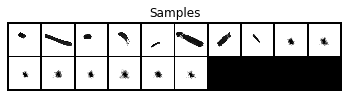

====> Test set loss: 159.6271
====> Recon loss: 147.5317
====> KL loss: 12.0953
Saving model, predictions and generated output for epoch 1 with Loss: 159.62707560494442
Train Epoch: 2 [0/593 (0%)]
loss: 163.37704467773438 recon: 151.73095703125 kl: 11.64608097076416 


/Users/manuelladron/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP_VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 2
Losses:  loss: 146.69017547607422 recon: 138.76467559814452 kl: 7.925500030517578 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


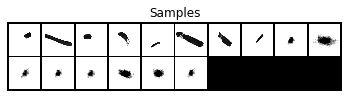

====> Test set loss: 147.7738
====> Recon loss: 141.0095
====> KL loss: 6.7643
Saving model, predictions and generated output for epoch 2 with Loss: 147.77379674719484
Train Epoch: 3 [0/593 (0%)]
loss: 178.8666534423828 recon: 172.59588623046875 kl: 6.270764350891113 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 3
Losses:  loss: 135.1707440185547 recon: 126.86128067016601 kl: 8.309462957382202 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


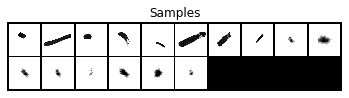

====> Test set loss: 138.9836
====> Recon loss: 131.7463
====> KL loss: 7.2373
Saving model, predictions and generated output for epoch 3 with Loss: 138.98360694014787
Train Epoch: 4 [0/593 (0%)]
loss: 107.40921020507812 recon: 98.46979522705078 kl: 8.939414978027344 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 4
Losses:  loss: 128.9190252685547 recon: 119.6672233581543 kl: 9.251801719665528 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


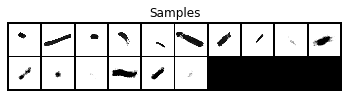

====> Test set loss: 126.2095
====> Recon loss: 117.7700
====> KL loss: 8.4395
Saving model, predictions and generated output for epoch 4 with Loss: 126.20947593330537
Train Epoch: 5 [0/593 (0%)]
loss: 110.8473892211914 recon: 102.4122085571289 kl: 8.435179710388184 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 5
Losses:  loss: 118.12787887573242 recon: 108.65916839599609 kl: 9.468710279464721 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


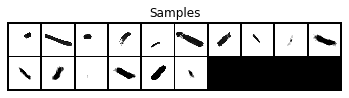

====> Test set loss: 117.6942
====> Recon loss: 108.5899
====> KL loss: 9.1043
Saving model, predictions and generated output for epoch 5 with Loss: 117.69419215669568
Train Epoch: 6 [0/593 (0%)]
loss: 126.9306640625 recon: 117.03836059570312 kl: 9.89230728149414 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 6
Losses:  loss: 111.27105880737305 recon: 101.3564584350586 kl: 9.91460018157959 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


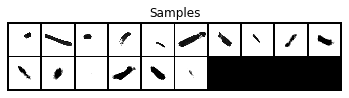

====> Test set loss: 110.8281
====> Recon loss: 102.0948
====> KL loss: 8.7333
Saving model, predictions and generated output for epoch 6 with Loss: 110.82813933711724
Train Epoch: 7 [0/593 (0%)]
loss: 105.9349365234375 recon: 96.6072006225586 kl: 9.327737808227539 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 7
Losses:  loss: 107.5392138671875 recon: 98.15763778686524 kl: 9.381575946807862 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


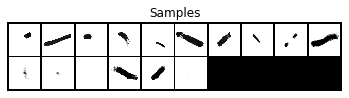

====> Test set loss: 112.3206
====> Recon loss: 103.3853
====> KL loss: 8.9353
Train Epoch: 8 [0/593 (0%)]
loss: 83.7308120727539 recon: 73.9837646484375 kl: 9.74704647064209 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 8
Losses:  loss: 108.41995986938477 recon: 98.70617568969726 kl: 9.71378436088562 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


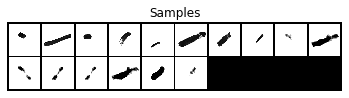

====> Test set loss: 104.9292
====> Recon loss: 94.7323
====> KL loss: 10.1969
Saving model, predictions and generated output for epoch 8 with Loss: 104.9292205196099
Train Epoch: 9 [0/593 (0%)]
loss: 125.6904296875 recon: 116.10198211669922 kl: 9.588449478149414 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 9
Losses:  loss: 103.23260391235351 recon: 92.71709632873535 kl: 10.515507335662841 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


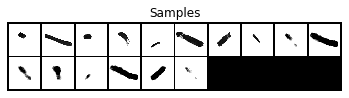

====> Test set loss: 104.1448
====> Recon loss: 94.1607
====> KL loss: 9.9841
Saving model, predictions and generated output for epoch 9 with Loss: 104.14478399289534
Train Epoch: 10 [0/593 (0%)]
loss: 102.48990631103516 recon: 92.49799346923828 kl: 9.991912841796875 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 10
Losses:  loss: 94.22336166381837 recon: 83.02655471801758 kl: 11.196806716918946 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


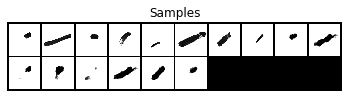

====> Test set loss: 97.2333
====> Recon loss: 86.4289
====> KL loss: 10.8044
Saving model, predictions and generated output for epoch 10 with Loss: 97.23332880007341
Train Epoch: 11 [0/593 (0%)]
loss: 82.98362731933594 recon: 72.44384765625 kl: 10.539777755737305 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 11
Losses:  loss: 88.83040283203125 recon: 78.01726760864258 kl: 10.813135318756103 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


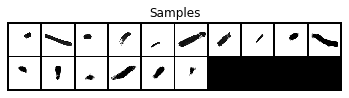

====> Test set loss: 98.3607
====> Recon loss: 87.7642
====> KL loss: 10.5965
Train Epoch: 12 [0/593 (0%)]
loss: 92.44581604003906 recon: 81.34479522705078 kl: 11.101019859313965 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 12
Losses:  loss: 90.63547386169434 recon: 79.34009468078614 kl: 11.295378608703613 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


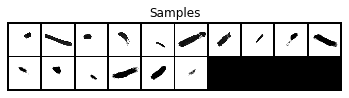

====> Test set loss: 95.3016
====> Recon loss: 83.4788
====> KL loss: 11.8228
Saving model, predictions and generated output for epoch 12 with Loss: 95.30164516372169
Train Epoch: 13 [0/593 (0%)]
loss: 87.12879943847656 recon: 75.6451644897461 kl: 11.483633041381836 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 13
Losses:  loss: 90.85367065429688 recon: 79.56193969726563 kl: 11.291730556488037 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


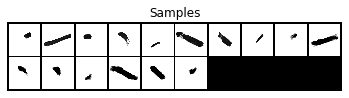

====> Test set loss: 91.5398
====> Recon loss: 79.6606
====> KL loss: 11.8792
Saving model, predictions and generated output for epoch 13 with Loss: 91.53979451224308
Train Epoch: 14 [0/593 (0%)]
loss: 94.64013671875 recon: 82.07138061523438 kl: 12.568758964538574 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 14
Losses:  loss: 89.20993499755859 recon: 78.41669807434081 kl: 10.793237285614014 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


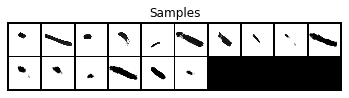

====> Test set loss: 91.1173
====> Recon loss: 79.8203
====> KL loss: 11.2970
Saving model, predictions and generated output for epoch 14 with Loss: 91.11733046154048
Train Epoch: 15 [0/593 (0%)]
loss: 98.38389587402344 recon: 85.33122253417969 kl: 13.05267333984375 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 15
Losses:  loss: 87.61629638671874 recon: 76.53629585266113 kl: 11.080000915527343 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


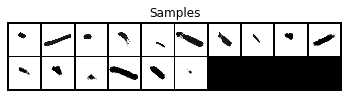

====> Test set loss: 89.4852
====> Recon loss: 78.1348
====> KL loss: 11.3504
Saving model, predictions and generated output for epoch 15 with Loss: 89.4851733726143
Train Epoch: 16 [0/593 (0%)]
loss: 73.25383758544922 recon: 62.32653045654297 kl: 10.927308082580566 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 16
Losses:  loss: 88.5197779083252 recon: 77.59079627990722 kl: 10.928981380462647 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


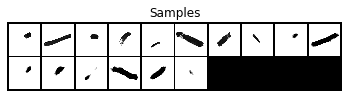

====> Test set loss: 90.6965
====> Recon loss: 78.9028
====> KL loss: 11.7937
Train Epoch: 17 [0/593 (0%)]
loss: 90.416748046875 recon: 78.29461669921875 kl: 12.122127532958984 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 17
Losses:  loss: 83.20826011657715 recon: 72.10198936462402 kl: 11.106270618438721 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


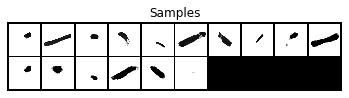

====> Test set loss: 87.3214
====> Recon loss: 76.2932
====> KL loss: 11.0282
Saving model, predictions and generated output for epoch 17 with Loss: 87.32140703649328
Train Epoch: 18 [0/593 (0%)]
loss: 85.51152801513672 recon: 74.49112701416016 kl: 11.020401000976562 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 18
Losses:  loss: 86.32156372070312 recon: 74.14580795288086 kl: 12.175755996704101 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


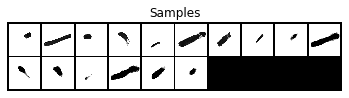

====> Test set loss: 87.5003
====> Recon loss: 75.7656
====> KL loss: 11.7347
Train Epoch: 19 [0/593 (0%)]
loss: 64.80712890625 recon: 53.81651306152344 kl: 10.990614891052246 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 19
Losses:  loss: 82.93060569763183 recon: 71.22106857299805 kl: 11.709537124633789 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


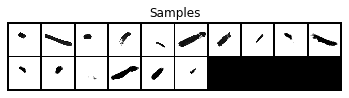

====> Test set loss: 88.1847
====> Recon loss: 76.3841
====> KL loss: 11.8006
Train Epoch: 20 [0/593 (0%)]
loss: 93.11929321289062 recon: 80.17001342773438 kl: 12.949275970458984 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 20
Losses:  loss: 83.43936294555664 recon: 71.69889205932617 kl: 11.740470714569092 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


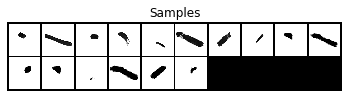

====> Test set loss: 88.7115
====> Recon loss: 77.0911
====> KL loss: 11.6204
Train Epoch: 21 [0/593 (0%)]
loss: 73.27146911621094 recon: 62.48253631591797 kl: 10.788932800292969 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 21
Losses:  loss: 81.56031341552735 recon: 69.32428840637208 kl: 12.236025161743164 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


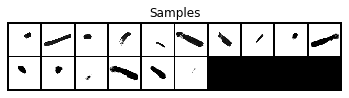

====> Test set loss: 83.9083
====> Recon loss: 72.3385
====> KL loss: 11.5699
Saving model, predictions and generated output for epoch 21 with Loss: 83.90831454488254
Train Epoch: 22 [0/593 (0%)]
loss: 91.11463928222656 recon: 80.47088623046875 kl: 10.643749237060547 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 22
Losses:  loss: 81.25934661865234 recon: 69.08458541870117 kl: 12.174761943817138 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


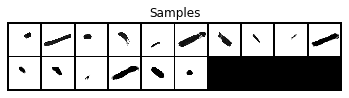

====> Test set loss: 87.3636
====> Recon loss: 75.2025
====> KL loss: 12.1610
Train Epoch: 23 [0/593 (0%)]
loss: 88.71455383300781 recon: 76.54947662353516 kl: 12.165079116821289 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 23
Losses:  loss: 80.93911926269531 recon: 69.21032943725587 kl: 11.728789939880372 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


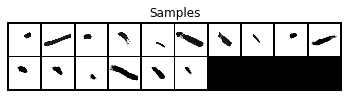

====> Test set loss: 83.6365
====> Recon loss: 72.5367
====> KL loss: 11.0998
Saving model, predictions and generated output for epoch 23 with Loss: 83.63649468133913
Train Epoch: 24 [0/593 (0%)]
loss: 77.3447494506836 recon: 66.8663558959961 kl: 10.478392601013184 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 24
Losses:  loss: 80.58056343078613 recon: 68.08915107727051 kl: 12.491412315368652 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


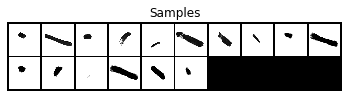

====> Test set loss: 83.0251
====> Recon loss: 71.1839
====> KL loss: 11.8413
Saving model, predictions and generated output for epoch 24 with Loss: 83.02514197842386
Train Epoch: 25 [0/593 (0%)]
loss: 63.20735168457031 recon: 52.92049789428711 kl: 10.286855697631836 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 25
Losses:  loss: 80.06523063659668 recon: 67.76384048461914 kl: 12.301390113830566 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


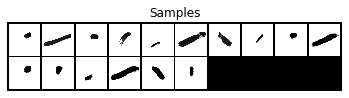

====> Test set loss: 84.3493
====> Recon loss: 72.1408
====> KL loss: 12.2085
Train Epoch: 26 [0/593 (0%)]
loss: 78.62107849121094 recon: 67.59170532226562 kl: 11.029372215270996 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 26
Losses:  loss: 76.58457511901855 recon: 64.48984344482422 kl: 12.094731674194335 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


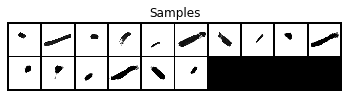

====> Test set loss: 84.7736
====> Recon loss: 72.4679
====> KL loss: 12.3057
Train Epoch: 27 [0/593 (0%)]
loss: 95.24365997314453 recon: 82.83597564697266 kl: 12.407681465148926 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 27
Losses:  loss: 78.52065689086913 recon: 65.98580711364747 kl: 12.534849662780761 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


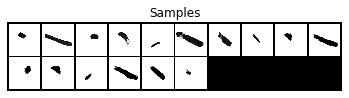

====> Test set loss: 82.7480
====> Recon loss: 70.7410
====> KL loss: 12.0070
Saving model, predictions and generated output for epoch 27 with Loss: 82.74804134496907
Train Epoch: 28 [0/593 (0%)]
loss: 70.2720947265625 recon: 58.77314758300781 kl: 11.498947143554688 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 28
Losses:  loss: 78.82690338134766 recon: 66.56885353088379 kl: 12.258049468994141 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


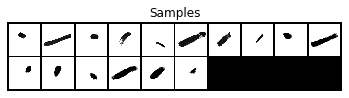

====> Test set loss: 82.8175
====> Recon loss: 70.8681
====> KL loss: 11.9494
Train Epoch: 29 [0/593 (0%)]
loss: 134.5860595703125 recon: 121.51863861083984 kl: 13.067428588867188 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 29
Losses:  loss: 76.19788063049316 recon: 63.80169746398926 kl: 12.396183185577392 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


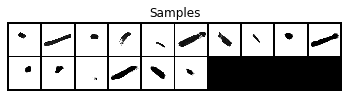

====> Test set loss: 81.8485
====> Recon loss: 69.7923
====> KL loss: 12.0561
Saving model, predictions and generated output for epoch 29 with Loss: 81.84845175519085
Train Epoch: 30 [0/593 (0%)]
loss: 83.50257110595703 recon: 70.44546508789062 kl: 13.057104110717773 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 30
Losses:  loss: 75.78830390930176 recon: 63.662965621948246 kl: 12.125338439941407 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


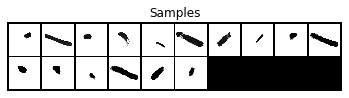

====> Test set loss: 82.7902
====> Recon loss: 69.8507
====> KL loss: 12.9395

----- FINAL RESULTS ------
Final -ELBO: 82.7902, Recon Loss: 69.8507, KL Loss: 12.9395


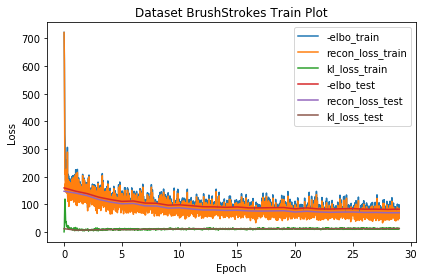

SAMPLES AS THEY COME:  (4, 1, 32, 32)
grid img shape:  torch.Size([3, 36, 138])


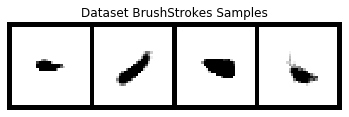

SAMPLES AS THEY COME:  (2, 1, 32, 32)
grid img shape:  torch.Size([3, 36, 70])


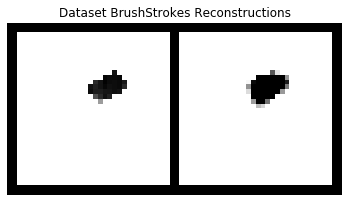

SAMPLES AS THEY COME:  (20, 1, 32, 32)
grid img shape:  torch.Size([3, 70, 342])


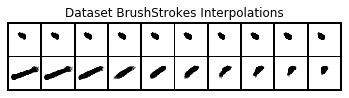

In [23]:
# model
model = MLP_VAE(16) # Alternative -> model = ConvVAEE((3, 32, 32), 16)
# model = ConvVAE(16)
model = model.to(device)
epochs = 30
batch_size = 8
# call functions
save_results(train_dataset, test_dataset, model, SAVE_PATH, train_procedure, epochs, batch_size, SAVE_PATH, cnn=False)

Train Epoch: 1 [0/593 (0%)]
loss: 704.1498413085938 recon: 704.1337890625 kl: 0.016040630638599396 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 1
Losses:  loss: 645.034658203125 recon: 644.0612194824218 kl: 0.9734401542693376 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


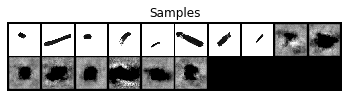

====> Test set loss: 577.8431
====> Recon loss: 574.8210
====> KL loss: 3.0221
Saving model, predictions and generated output for epoch 1 with Loss: 577.8430945889262


/Users/manuelladron/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/manuelladron/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/manuelladron/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train Epoch: 2 [0/593 (0%)]
loss: 598.2686767578125 recon: 595.934326171875 kl: 2.33436918258667 


/Users/manuelladron/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvVAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 2
Losses:  loss: 484.3838665771484 recon: 477.61423950195314 kl: 6.76962384223938 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


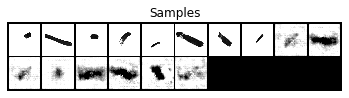

====> Test set loss: 368.4411
====> Recon loss: 364.8335
====> KL loss: 3.6076
Saving model, predictions and generated output for epoch 2 with Loss: 368.44111623059985
Train Epoch: 3 [0/593 (0%)]
loss: 417.43804931640625 recon: 414.45989990234375 kl: 2.978149652481079 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 3
Losses:  loss: 305.342057800293 recon: 298.035114440918 kl: 7.306944012641907 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


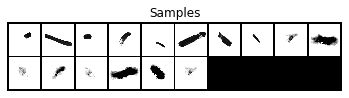

====> Test set loss: 306.8352
====> Recon loss: 295.1263
====> KL loss: 11.7088
Saving model, predictions and generated output for epoch 3 with Loss: 306.8351821387374
Train Epoch: 4 [0/593 (0%)]
loss: 239.26980590820312 recon: 227.87045288085938 kl: 11.39935302734375 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 4
Losses:  loss: 211.6364880371094 recon: 203.42080352783202 kl: 8.2156844997406 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


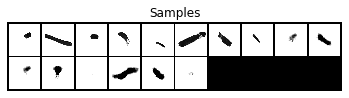

====> Test set loss: 174.7955
====> Recon loss: 167.8061
====> KL loss: 6.9894
Saving model, predictions and generated output for epoch 4 with Loss: 174.7955281302433
Train Epoch: 5 [0/593 (0%)]
loss: 174.02232360839844 recon: 164.79922485351562 kl: 9.223105430603027 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 5
Losses:  loss: 157.2094320678711 recon: 149.35044631958007 kl: 7.858985595703125 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


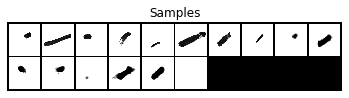

====> Test set loss: 136.0971
====> Recon loss: 127.4421
====> KL loss: 8.6550
Saving model, predictions and generated output for epoch 5 with Loss: 136.09710734322567
Train Epoch: 6 [0/593 (0%)]
loss: 124.75433349609375 recon: 117.94474792480469 kl: 6.809581756591797 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 6
Losses:  loss: 132.69494689941405 recon: 125.09405044555665 kl: 7.600895757675171 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


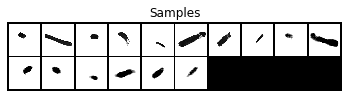

====> Test set loss: 120.2655
====> Recon loss: 113.6402
====> KL loss: 6.6253
Saving model, predictions and generated output for epoch 6 with Loss: 120.26550006226405
Train Epoch: 7 [0/593 (0%)]
loss: 95.50852966308594 recon: 90.18304443359375 kl: 5.325481414794922 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 7
Losses:  loss: 120.36874450683594 recon: 112.47310516357422 kl: 7.895639200210571 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


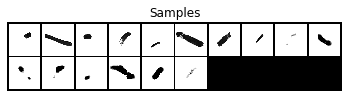

====> Test set loss: 111.1490
====> Recon loss: 103.9612
====> KL loss: 7.1878
Saving model, predictions and generated output for epoch 7 with Loss: 111.14895937106753
Train Epoch: 8 [0/593 (0%)]
loss: 115.73440551757812 recon: 109.810791015625 kl: 5.923614978790283 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 8
Losses:  loss: 105.8260597229004 recon: 98.12732650756836 kl: 7.698732833862305 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


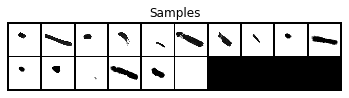

====> Test set loss: 102.8823
====> Recon loss: 95.1518
====> KL loss: 7.7304
Saving model, predictions and generated output for epoch 8 with Loss: 102.88227465328754
Train Epoch: 9 [0/593 (0%)]
loss: 98.99639129638672 recon: 92.24422454833984 kl: 6.752165794372559 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 9
Losses:  loss: 104.74925857543946 recon: 96.74318756103516 kl: 8.00607129096985 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


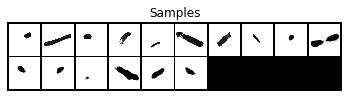

====> Test set loss: 97.7796
====> Recon loss: 89.9916
====> KL loss: 7.7880
Saving model, predictions and generated output for epoch 9 with Loss: 97.77958034028943
Train Epoch: 10 [0/593 (0%)]
loss: 89.84757232666016 recon: 82.23818969726562 kl: 7.609385013580322 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 10
Losses:  loss: 104.01461395263672 recon: 94.680523147583 kl: 9.334090223312378 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


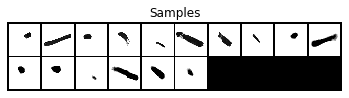

====> Test set loss: 92.6863
====> Recon loss: 83.6453
====> KL loss: 9.0410
Saving model, predictions and generated output for epoch 10 with Loss: 92.68628789914534
Train Epoch: 11 [0/593 (0%)]
loss: 110.7407455444336 recon: 100.60147857666016 kl: 10.13926887512207 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 11
Losses:  loss: 97.26070343017578 recon: 88.08052207946777 kl: 9.180181169509888 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


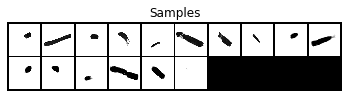

====> Test set loss: 94.1751
====> Recon loss: 84.6868
====> KL loss: 9.4883
Train Epoch: 12 [0/593 (0%)]
loss: 103.20405578613281 recon: 93.39042663574219 kl: 9.81363296508789 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 12
Losses:  loss: 96.99124328613281 recon: 87.59305793762206 kl: 9.398185472488404 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


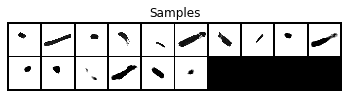

====> Test set loss: 92.2661
====> Recon loss: 82.0825
====> KL loss: 10.1837
Saving model, predictions and generated output for epoch 12 with Loss: 92.26613130505453
Train Epoch: 13 [0/593 (0%)]
loss: 77.39183044433594 recon: 66.84395599365234 kl: 10.547874450683594 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 13
Losses:  loss: 98.94191513061523 recon: 89.55358963012695 kl: 9.388325309753418 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


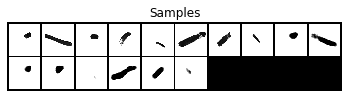

====> Test set loss: 90.1642
====> Recon loss: 81.1057
====> KL loss: 9.0585
Saving model, predictions and generated output for epoch 13 with Loss: 90.1641845703125
Train Epoch: 14 [0/593 (0%)]
loss: 77.476318359375 recon: 69.63636779785156 kl: 7.839954376220703 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 14
Losses:  loss: 96.64201354980469 recon: 87.41397186279296 kl: 9.228041114807128 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


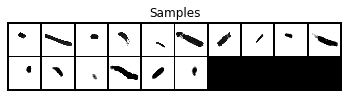

====> Test set loss: 93.7207
====> Recon loss: 83.5156
====> KL loss: 10.2051
Train Epoch: 15 [0/593 (0%)]
loss: 132.89427185058594 recon: 123.37010955810547 kl: 9.524166107177734 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 15
Losses:  loss: 95.06210273742676 recon: 85.48207374572753 kl: 9.580029191970825 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


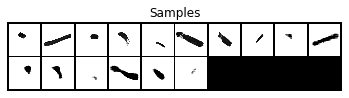

====> Test set loss: 89.9678
====> Recon loss: 80.0905
====> KL loss: 9.8773
Saving model, predictions and generated output for epoch 15 with Loss: 89.96776729302118
Train Epoch: 16 [0/593 (0%)]
loss: 77.14524841308594 recon: 66.88239288330078 kl: 10.262855529785156 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 16
Losses:  loss: 92.57839454650879 recon: 83.3755696105957 kl: 9.202824850082397 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


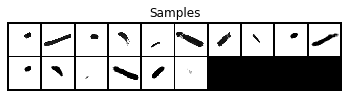

====> Test set loss: 88.9120
====> Recon loss: 79.2957
====> KL loss: 9.6163
Saving model, predictions and generated output for epoch 16 with Loss: 88.91202826787962
Train Epoch: 17 [0/593 (0%)]
loss: 76.3121109008789 recon: 67.06535339355469 kl: 9.246758460998535 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 17
Losses:  loss: 92.38753395080566 recon: 83.36845939636231 kl: 9.01907488822937 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


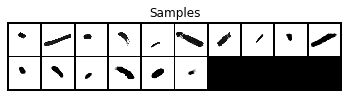

====> Test set loss: 95.4957
====> Recon loss: 86.9758
====> KL loss: 8.5199
Train Epoch: 18 [0/593 (0%)]
loss: 66.31240844726562 recon: 58.12947463989258 kl: 8.18293571472168 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 18
Losses:  loss: 94.22292335510254 recon: 85.12616271972657 kl: 9.096760034561157 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


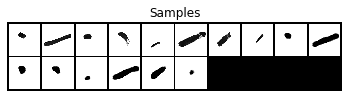

====> Test set loss: 85.2465
====> Recon loss: 75.2461
====> KL loss: 10.0004
Saving model, predictions and generated output for epoch 18 with Loss: 85.24652202017356
Train Epoch: 19 [0/593 (0%)]
loss: 77.9466552734375 recon: 68.08451843261719 kl: 9.862140655517578 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 19
Losses:  loss: 94.0458406829834 recon: 84.79890640258789 kl: 9.246934366226196 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


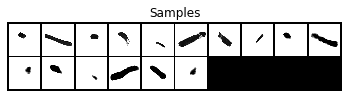

====> Test set loss: 87.3559
====> Recon loss: 77.9950
====> KL loss: 9.3609
Train Epoch: 20 [0/593 (0%)]
loss: 91.27381896972656 recon: 81.77229309082031 kl: 9.501527786254883 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 20
Losses:  loss: 89.2266976928711 recon: 79.78012481689453 kl: 9.446573057174682 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


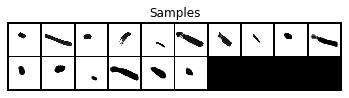

====> Test set loss: 87.6715
====> Recon loss: 80.0502
====> KL loss: 7.6213
Train Epoch: 21 [0/593 (0%)]
loss: 106.3598861694336 recon: 99.40103149414062 kl: 6.958858013153076 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 21
Losses:  loss: 89.74457580566406 recon: 80.47557495117188 kl: 9.269000663757325 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


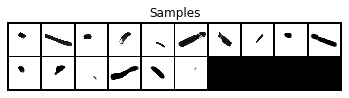

====> Test set loss: 84.6348
====> Recon loss: 74.8116
====> KL loss: 9.8232
Saving model, predictions and generated output for epoch 21 with Loss: 84.63476439610423
Train Epoch: 22 [0/593 (0%)]
loss: 75.37982940673828 recon: 65.90911865234375 kl: 9.470712661743164 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 22
Losses:  loss: 91.75124328613282 recon: 82.51035018920898 kl: 9.24089331626892 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


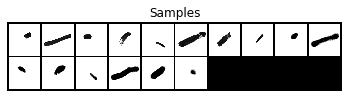

====> Test set loss: 87.2479
====> Recon loss: 76.7235
====> KL loss: 10.5244
Train Epoch: 23 [0/593 (0%)]
loss: 161.1129608154297 recon: 147.16355895996094 kl: 13.949406623840332 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 23
Losses:  loss: 88.0440071105957 recon: 78.44182708740234 kl: 9.6021803855896 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


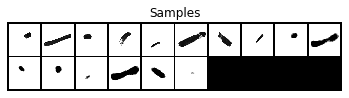

====> Test set loss: 91.5723
====> Recon loss: 81.1160
====> KL loss: 10.4563
Train Epoch: 24 [0/593 (0%)]
loss: 96.0246810913086 recon: 84.16002655029297 kl: 11.864655494689941 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 24
Losses:  loss: 88.21842353820801 recon: 79.05124938964843 kl: 9.167174243927002 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


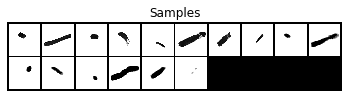

====> Test set loss: 87.5262
====> Recon loss: 77.3212
====> KL loss: 10.2050
Train Epoch: 25 [0/593 (0%)]
loss: 103.97689819335938 recon: 94.11957550048828 kl: 9.85732364654541 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 25
Losses:  loss: 89.52169647216797 recon: 80.14434913635255 kl: 9.377347497940063 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


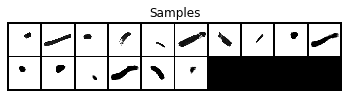

====> Test set loss: 87.1336
====> Recon loss: 76.8480
====> KL loss: 10.2855
Train Epoch: 26 [0/593 (0%)]
loss: 92.19978332519531 recon: 79.09342193603516 kl: 13.106365203857422 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 26
Losses:  loss: 87.27917831420899 recon: 77.94237747192383 kl: 9.336801090240478 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


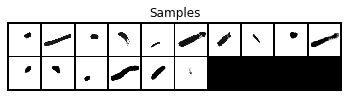

====> Test set loss: 82.1712
====> Recon loss: 72.7633
====> KL loss: 9.4079
Saving model, predictions and generated output for epoch 26 with Loss: 82.17117452941486
Train Epoch: 27 [0/593 (0%)]
loss: 91.16478729248047 recon: 80.53321838378906 kl: 10.631566047668457 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 27
Losses:  loss: 89.33006134033204 recon: 79.69098518371582 kl: 9.639076099395751 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


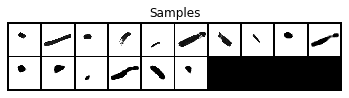

====> Test set loss: 86.2114
====> Recon loss: 76.3824
====> KL loss: 9.8290
Train Epoch: 28 [0/593 (0%)]
loss: 97.23257446289062 recon: 87.7480239868164 kl: 9.484551429748535 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 28
Losses:  loss: 89.28611656188964 recon: 79.27792335510254 kl: 10.008193340301514 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


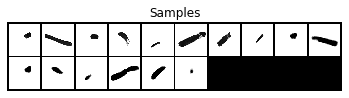

====> Test set loss: 85.3883
====> Recon loss: 75.5986
====> KL loss: 9.7897
Train Epoch: 29 [0/593 (0%)]
loss: 97.5325698852539 recon: 87.7962875366211 kl: 9.736281394958496 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 29
Losses:  loss: 86.61755912780762 recon: 77.13439628601074 kl: 9.483162126541139 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


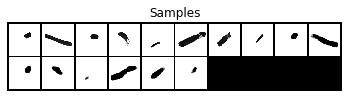

====> Test set loss: 82.5043
====> Recon loss: 72.8184
====> KL loss: 9.6859
Train Epoch: 30 [0/593 (0%)]
loss: 82.74848937988281 recon: 74.4736328125 kl: 8.27485466003418 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 30
Losses:  loss: 83.94434043884277 recon: 74.49310844421387 kl: 9.451231746673583 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


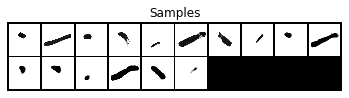

====> Test set loss: 82.8973
====> Recon loss: 73.1684
====> KL loss: 9.7289

----- FINAL RESULTS ------
Final -ELBO: 82.8973, Recon Loss: 73.1684, KL Loss: 9.7289


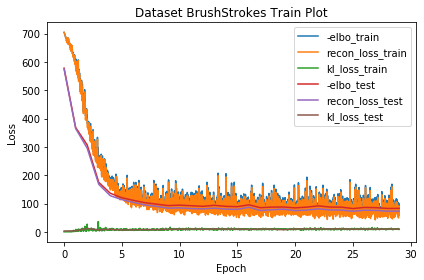

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES AS THEY COME:  (4, 1, 32, 32)
grid img shape:  torch.Size([3, 36, 138])


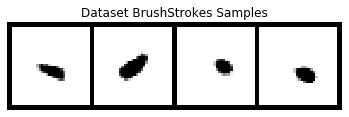

SAMPLES AS THEY COME:  (2, 1, 32, 32)
grid img shape:  torch.Size([3, 36, 70])


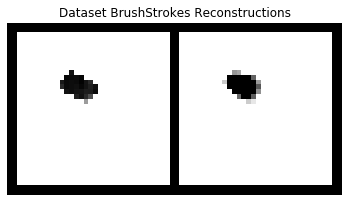

SAMPLES AS THEY COME:  (20, 1, 32, 32)
grid img shape:  torch.Size([3, 70, 342])


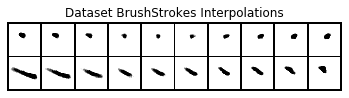

In [25]:
# model
model = ConvVAE(16) # Alternative -> model = ConvVAEE((3, 32, 32), 16)
# model = ConvVAE(16)
model = model.to(device)
epochs = 30
batch_size = 8
# call functions
save_results(train_dataset, test_dataset, model, SAVE_PATH, train_procedure, epochs, batch_size, SAVE_PATH, cnn=True)

Train Epoch: 1 [0/593 (0%)]
loss: 740.0394287109375 recon: 740.033935546875 kl: 0.005482008680701256 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 1
Losses:  loss: 681.1096691894531 recon: 680.7841577148438 kl: 0.3255145318247378 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


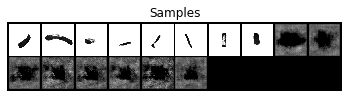

====> Test set loss: 618.8961
====> Recon loss: 616.1387
====> KL loss: 2.7574
Saving model, predictions and generated output for epoch 1 with Loss: 618.8961009595218


/Users/manuelladron/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/manuelladron/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/manuelladron/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train Epoch: 2 [0/593 (0%)]
loss: 646.0573120117188 recon: 644.269287109375 kl: 1.788010835647583 


/Users/manuelladron/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvVAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 2
Losses:  loss: 502.1201916503906 recon: 495.89969543457033 kl: 6.220496973991394 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


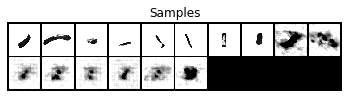

====> Test set loss: 404.7837
====> Recon loss: 400.7860
====> KL loss: 3.9978
Saving model, predictions and generated output for epoch 2 with Loss: 404.78373236944213
Train Epoch: 3 [0/593 (0%)]
loss: 404.9020080566406 recon: 399.9082946777344 kl: 4.993714332580566 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 3
Losses:  loss: 319.6437512207031 recon: 312.03388458251953 kl: 7.6098685598373415 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


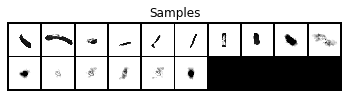

====> Test set loss: 249.0326
====> Recon loss: 242.9040
====> KL loss: 6.1285
Saving model, predictions and generated output for epoch 3 with Loss: 249.03259768902055
Train Epoch: 4 [0/593 (0%)]
loss: 271.7026062011719 recon: 266.10186767578125 kl: 5.600736618041992 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 4
Losses:  loss: 225.14421478271484 recon: 217.59189971923828 kl: 7.5523166704177855 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


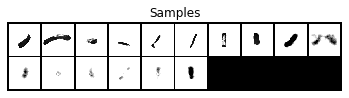

====> Test set loss: 175.2762
====> Recon loss: 170.8150
====> KL loss: 4.4612
Saving model, predictions and generated output for epoch 4 with Loss: 175.27623610528522
Train Epoch: 5 [0/593 (0%)]
loss: 241.63345336914062 recon: 237.73248291015625 kl: 3.9009673595428467 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 5
Losses:  loss: 171.4377282714844 recon: 164.56692138671875 kl: 6.870807313919068 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


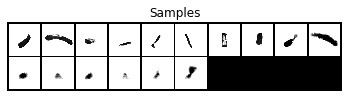

====> Test set loss: 151.3162
====> Recon loss: 141.1594
====> KL loss: 10.1568
Saving model, predictions and generated output for epoch 5 with Loss: 151.316208807414
Train Epoch: 6 [0/593 (0%)]
loss: 144.58534240722656 recon: 134.33584594726562 kl: 10.249502182006836 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 6
Losses:  loss: 142.2899690246582 recon: 134.52809967041014 kl: 7.761868848800659 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


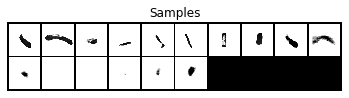

====> Test set loss: 119.5112
====> Recon loss: 112.1711
====> KL loss: 7.3401
Saving model, predictions and generated output for epoch 6 with Loss: 119.51117680696834
Train Epoch: 7 [0/593 (0%)]
loss: 148.16812133789062 recon: 140.7945556640625 kl: 7.37355899810791 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 7
Losses:  loss: 123.67510711669922 recon: 116.21386428833007 kl: 7.461243629455566 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


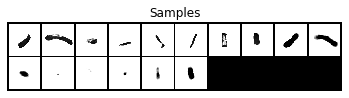

====> Test set loss: 105.6768
====> Recon loss: 96.8315
====> KL loss: 8.8453
Saving model, predictions and generated output for epoch 7 with Loss: 105.67678402894295
Train Epoch: 8 [0/593 (0%)]
loss: 125.41033172607422 recon: 117.14122009277344 kl: 8.269113540649414 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 8
Losses:  loss: 114.11116119384765 recon: 106.73668258666993 kl: 7.374478607177735 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


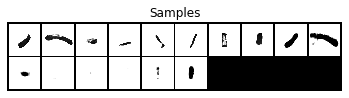

====> Test set loss: 97.7070
====> Recon loss: 88.2713
====> KL loss: 9.4357
Saving model, predictions and generated output for epoch 8 with Loss: 97.7069693955799
Train Epoch: 9 [0/593 (0%)]
loss: 146.05775451660156 recon: 135.39065551757812 kl: 10.667097091674805 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 9
Losses:  loss: 109.6849040222168 recon: 102.32059219360352 kl: 7.364311571121216 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


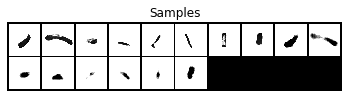

====> Test set loss: 96.4855
====> Recon loss: 88.6003
====> KL loss: 7.8852
Saving model, predictions and generated output for epoch 9 with Loss: 96.48550394557466
Train Epoch: 10 [0/593 (0%)]
loss: 125.38652801513672 recon: 117.1163330078125 kl: 8.270195007324219 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ====> After training the Epoch: 10
Losses:  loss: 102.1491926574707 recon: 95.17067810058593 kl: 6.978514642715454 
SAMPLES AS THEY COME:  torch.Size([16, 1, 32, 32])
grid img shape:  torch.Size([3, 70, 342])


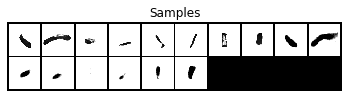

====> Test set loss: 92.7420
====> Recon loss: 85.5901
====> KL loss: 7.1520
Saving model, predictions and generated output for epoch 10 with Loss: 92.74201258716967

----- FINAL RESULTS ------
Final -ELBO: 92.7420, Recon Loss: 85.5901, KL Loss: 7.1520


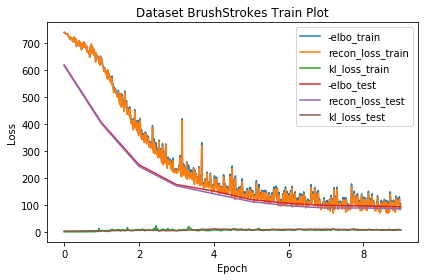

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES AS THEY COME:  (4, 1, 32, 32)
grid img shape:  torch.Size([3, 36, 138])


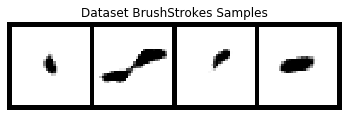

SAMPLES AS THEY COME:  (2, 1, 32, 32)
grid img shape:  torch.Size([3, 36, 70])


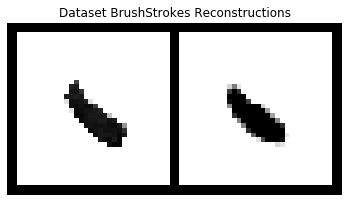

SAMPLES AS THEY COME:  (20, 1, 32, 32)
grid img shape:  torch.Size([3, 70, 342])


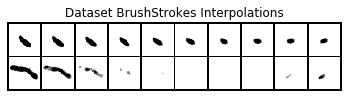

In [152]:
# model
model = ConvVAE(8) 
model = model.to(device)
epochs = 10
batch_size = 8
# call functions
save_results(train_dataset, test_dataset, model, SAVE_PATH, train_procedure, epochs, batch_size, SAVE_PATH, cnn=True)